# Image Assembly

Converting raw scanimage-tiff files into fused z-planes.

## Quickstart

All you need is a path to your .tiffs and a place to save them.
``` python
import mbo_utilities as mbo
``` python
scan = mbo.read_scan(r"path/to/tiffs*") # glob or list of filepaths (see mbo.get_files)
mbo.save_as(scan, "/path/to/save") # defaults to saving plane_01.tiff, plane_02.tiff ... 
```


In [1]:
from pathlib import Path
import numpy as np

import fastplotlib as fpl
import mbo_utilities as mbo

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

Valid,Device,Type,Backend,Driver
✅ (default),NVIDIA RTX A4000,DiscreteGPU,Vulkan,560.94
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
✅,NVIDIA RTX A4000,DiscreteGPU,D3D12,
❗ limited,Microsoft Basic Render Driver,CPU,D3D12,
❌,NVIDIA RTX A4000/PCIe/SSE2,Unknown,OpenGL,4.6.0 NVIDIA 560.94


## Input data: Path to your raw .tiff file(s)

Make sure your `data_path` contains only `.tiff` files for this imaging session. If there are other `.tiff` files, such as from another session or a processed file for this session, those files will be included in the scan and lead to errors.

## Initialize a scanreader object

Pass a list of files, or a wildcard string (e.g. "/path/to/files/*"matches all files in that directory) to {func}`mbo_utilities.read_scan`.

``` {tip}
mbo.get_files() is useful to easily get all files of the same filetype
```

In [2]:
files = mbo.get_files("D://demo//raw_data", 'tif')
files[0], len(files)

('D:\\demo\\raw_data\\demo_lbm_raw_00000.tif', 11)

In [3]:
scan = mbo.read_scan(files)
print(f"Lazy Array shape: {scan.shape}")  # T, Z, X, Y
print(f'Planes: {scan.num_channels}')
print(f'Frames: {scan.num_frames}')
print(f'ROIs: {scan.num_rois}')
print(f'frame-rate: {scan.fps}')

Lazy Array shape: (1437, 14, 448, 448)
Planes: 14
Frames: 1437
ROIs: 2
frame-rate: 17.06701142272251



This will display a widget allowing you to scroll in time and in z.

numpy like indexing:
``` python
frame = scan[0, 0, :, :] # first frame, plane1
zplane7 = scan[:, 6, :, :] # z-plane 6
zplane7 = scan[:, 6, :, :] # z-plane 6
```

Data provided and set.
Is running jupyter


RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
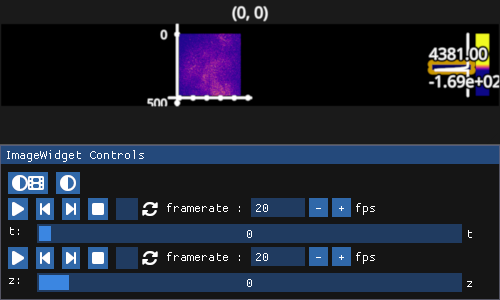

In [13]:
from mbo_utilities.graphics.imgui import PollenCalibrationWidget
iw = mbo.run_gui(scan)
iw.show()

In [12]:
gui = PollenCalibrationWidget(iw=iw)
iw.figure.add_gui(gui)

In [17]:
image_widget.close()

## Save assembled files

The currently supported file extensions are `.tiff`.

In [20]:
save_path = Path("/home/flynn/lbm_data/mk301/assembled")
save_path.mkdir(exist_ok=True)

mbo.save_as(
    scan,
    save_path,
    planes=[0, 6, 13],      # for 14 z-planes, first, middle, last 
    overwrite=True,
    ext = '.tiff',
    trim_edge=[2, 2, 2, 2], # post-assembly pixels to trim [left, right, top, bottom]
    append_str="_demo",      # this will be appended to the filename, 'plane_N_demo.ext'
    fix_phase=False          # fix bi-directional scan phase offset
)

Reading tiff series data...
Reading tiff pages...
Raw tiff fully read.
Saving 1437x14x448x448 in /home/flynn/lbm_data/mk301/assembled
[2, 2, 2, 2]
New height: 444
New width: 444


Saving plane 1:   0%|          | 0/56 [00:00<?, ?it/s]

Saving plane 7:   0%|          | 0/56 [00:00<?, ?it/s]

Saving plane 14:   0%|          | 0/56 [00:00<?, ?it/s]

Time elapsed: 0 minutes 5 seconds.


## Vizualize data with [fastplotlib](https://www.fastplotlib.org/user_guide/guide.html#what-is-fastplotlib)

To get a rough idea of the quality of your extracted timeseries, we can create a fastplotlib visualization to preview traces of individual pixels.

Here, we simply click on any pixel in the movie, and we get a 2D trace (or "temporal component" as used in this field) of the pixel through the course of the movie:

```{figure} ../_images/raw_data_preview.png
:align: center
```

More advanced visualizations can be easily created, i.e. adding a baseline subtracted element to the trace, or passing the trace through a frequency filter.

In [2]:
import tifffile
from ipywidgets import VBox

img = tifffile.memmap("/home/flynn/lbm_data/mk301/assembled/plane_07_demo.tiff")
iw_movie = fpl.ImageWidget(img, cmap="viridis")

tfig = fpl.Figure()

raw_trace = tfig[0, 0].add_line(np.zeros(img.shape[0]))

@iw_movie.managed_graphics[0].add_event_handler("click")
def pixel_clicked(ev):
    col, row = ev.pick_info["index"]
    raw_trace.data[:, 1] =  iw_movie.data[0][:, row, col]
    tfig[0, 0].auto_scale(maintain_aspect=False)

VBox([iw_movie.show(), tfig.show()])

NameError: name 'fpl' is not defined